**Import Libraries**

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import pandas as pd
import time
import random
import numpy as np
from nltk.stem import SnowballStemmer
import string
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score
from nltk.corpus import stopwords
import nltk
import re
import matplotlib
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk import FreqDist
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.metrics import mean_squared_error
import seaborn as sns
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chonn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Create function that scrapes reddit**

In [3]:
def reddit_to_csv(subreddit, filename, n_requests):

    #Create an empty list to be used later in function:
    posts = []

    #Create User-Agent
    headers = {'User-Agent': 'Knock Knock 914'}

    #Establish that 'after' (a variable used later) is None type:
    after = None

    #for loop n_requests iterations (n_requests is established by user):
    for i in range(n_requests):
        #Print i to inform user how far along function is:
        print(i)

        #At first, 'after' will be None, as established above, making params, initially, an empty dictionary
        #without any parameters set.  After the first iteration, 'after' will be given a value containing an id
        #tag of the last post pulled in that iteration's request, allowing the function to continue looping
        #through the next set of posts instead of continuously pulling the same 25 posts, for example.

        if after == None:
            params = {}
        else:
            params = {'after': after}

        #Assign 'url' to reddit's base url, plus whatever subreddit the user provides, plus .json for clean results:
        url = 'https://www.reddit.com/' + str(subreddit) + '/.json'

        #Set my res variable equal to the results from requests.get, and the parameters set above like 'url' or 'params':
        res = requests.get(url, params = params, headers = headers)

        #Conditional statement to ensure access to the API is approved:
        if res.status_code == 200:

            the_json = res.json()

            for x in range(len(the_json['data']['children'])):

                #Create temporary dictionary to add results of each post to:
                temp_dict = {}

                #After looking through the json results, I've selected the below information about the posts
                #as those that can potentially add value to my model's results.
                temp_dict['subreddit'] = the_json['data']['children'][x]['data']['subreddit']
                temp_dict['title'] = the_json['data']['children'][x]['data']['title']
                temp_dict['post_paragraph'] = the_json['data']['children'][x]['data']['selftext']
                temp_dict['clicked'] = the_json['data']['children'][x]['data']['clicked']
                temp_dict['ups'] = the_json['data']['children'][x]['data']['ups']
                temp_dict['downs'] = the_json['data']['children'][x]['data']['downs']
                temp_dict['likes'] = the_json['data']['children'][x]['data']['likes']
                temp_dict['category'] = the_json['data']['children'][x]['data']['category']
                temp_dict['number_of_comments'] = the_json['data']['children'][x]['data']['num_comments']
                temp_dict['score'] = the_json['data']['children'][x]['data']['score']
                temp_dict['author_flair_css_class'] = the_json['data']['children'][x]['data']['author_flair_css_class']
                temp_dict['subreddit_type'] = the_json['data']['children'][x]['data']['subreddit_type']

                #Add the temporary dictionary to 'posts',the list of each post's dictionary of information:
                posts.append(temp_dict)

            after = the_json['data']['after']

        else:
            print(res.status_code)
            break

        #Enter a delay of one second in the requests to reddit's API for good internet citizenship:
        time.sleep(5)

    #Turn the list of post dictionaries into a pandas DataFrame:
    posts_df = pd.DataFrame(posts)

    #Drop any duplicate rows that may have been pulled:
    posts_df.drop_duplicates(inplace = True)

    #Rearrange the columns into a more logical order:
    posts_df = posts_df[['subreddit', 'title', 'clicked', 'ups', 'downs', 'post_paragraph', 'likes', 'number_of_comments', 'category', 'score', 'author_flair_css_class', 'subreddit_type']]

    #Save the DataFrame as a .csv file:
    posts_df.to_csv(str(filename), index = False, sep = ",")

In [4]:
df_dc = pd.read_csv('DCcomics_reddit_posts.csv')
df_marvel = pd.read_csv('Marvel_reddit_posts.csv')
print(df_dc.shape)
print(df_marvel.shape)
df_dc.drop_duplicates(subset='title', inplace=True)
df_marvel.drop_duplicates(subset='title', inplace=True)
print(df_dc.shape)
print(df_marvel.shape)

(2185, 12)
(1995, 12)
(861, 12)
(973, 12)


**Merge two dataframes**

In [5]:
df = df_dc.append(df_marvel, ignore_index=True)
print(df.shape)

(1834, 12)


C:\Users\Chonn\AppData\Local\Temp\ipykernel_24332\672688365.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_dc.append(df_marvel, ignore_index=True)


In [6]:
df.head()

subreddit                                              title  clicked  ups  \
0  DCcomics  Weekly Discussion Thread: Comics, TV, and More...    False   14   
1  DCcomics  What Are You Reading? 11/06/2023 - No More Spo...    False    7   
2  DCcomics        [Comic Excerpt] The Detective (Batman #139)    False  150   
3  DCcomics         [Comic Excerpt] A moment made for this sub    False  118   
4  DCcomics  [Comic Excerpt] Cass Practicing her goodbyes b...    False   23   

   downs                                     post_paragraph  likes  \
0      0  Hey there honorary Justice League members - it...    NaN   
1      0  # Hello and welcome to our Weekly "What Are Yo...    NaN   
2      0                                                NaN    NaN   
3      0                                                NaN    NaN   
4      0                                                NaN    NaN   

   number_of_comments  category  score author_flair_css_class subreddit_type  
0                 117       NaN     14                    NaN         public  
1                   6       NaN      7                    NaN         public  
2                  11       NaN    150                    NaN         public  
3                   9       NaN    118                    NaN         public  
4                   2       NaN     23                    NaN         public

**Drop any duplicate rows**

In [7]:
df.drop_duplicates(inplace = True)

print("After Drop")
print(df.shape)

After Drop
(1834, 12)


**Create a 'target' column (will equal 1 if the post's subreddit is DC, and 0 if the post's subreddit is Marvel):**

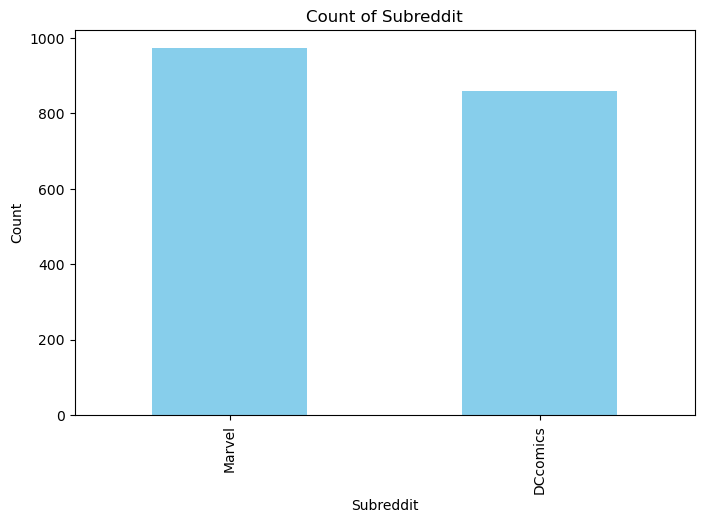

In [8]:
# Using Matplotlib
plt.figure(figsize=(8, 5))
df['subreddit'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Count of Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Count')
plt.show()

In [9]:
df['target'] = np.where(df['subreddit'] == 'DCcomics', 1, 0)

In [10]:
df

subreddit                                              title  clicked  \
0     DCcomics  Weekly Discussion Thread: Comics, TV, and More...    False   
1     DCcomics  What Are You Reading? 11/06/2023 - No More Spo...    False   
2     DCcomics        [Comic Excerpt] The Detective (Batman #139)    False   
3     DCcomics         [Comic Excerpt] A moment made for this sub    False   
4     DCcomics  [Comic Excerpt] Cass Practicing her goodbyes b...    False   
...        ...                                                ...      ...   
1829    Marvel  LEGO Marvel Avengers: Code Red | Official Trai...    False   
1830    Marvel  Controversial Opinion, but, I actually thoroug...    False   
1831    Marvel        How i would bring doctor doom into the mcu:    False   
1832    Marvel  Predator Vs Wolverine Vol 1 #4 (2023) Bill Sie...    False   
1833    Marvel                                      Beast is back    False   

      ups  downs                                     post_paragraph  likes  \
0      14      0  Hey there honorary Justice League members - it...    NaN   
1       7      0  # Hello and welcome to our Weekly "What Are Yo...    NaN   
2     150      0                                                NaN    NaN   
3     118      0                                                NaN    NaN   
4      23      0                                                NaN    NaN   
...   ...    ...                                                ...    ...   
1829    1      0                                                NaN    NaN   
1830    0      0  I know a lot of people hate on the show alot, ...    NaN   
1831    0      0  Make him the villain of the fantastic 4 movie,...    NaN   
1832    1      0                                                NaN    NaN   
1833    1      0                                                NaN    NaN   

      number_of_comments  category  score author_flair_css_class  \
0                    117       NaN     14                    NaN   
1                      6       NaN      7                    NaN   
2                     11       NaN    150                    NaN   
3                      9       NaN    118                    NaN   
4                      2       NaN     23                    NaN   
...                  ...       ...    ...                    ...   
1829                   0       NaN      1    IronManExtremis two   
1830                  17       NaN      0                    NaN   
1831                   1       NaN      0                    NaN   
1832                   0       NaN      1                    NaN   
1833                   0       NaN      1                    NaN   

     subreddit_type  target  
0            public       1  
1            public       1  
2            public       1  
3            public       1  
4            public       1  
...             ...     ...  
1829         public       0  
1830         public       0  
1831         public       0  
1832         public       0  
1833         public       0  

[1834 rows x 13 columns]

**Look for columns that don't have any values**

In [11]:
df.isnull().sum()

subreddit                    0
title                        0
clicked                      0
ups                          0
downs                        0
post_paragraph             915
likes                     1834
number_of_comments           0
category                  1834
score                        0
author_flair_css_class    1687
subreddit_type               0
target                       0
dtype: int64

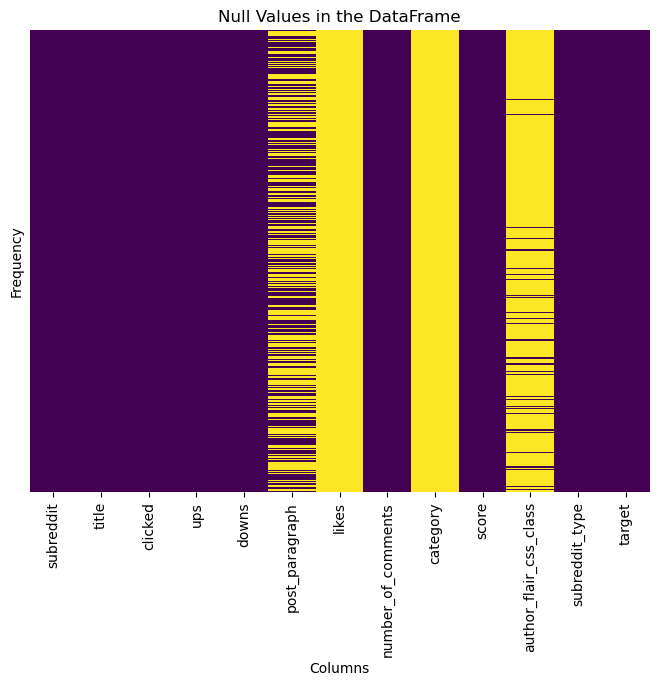

In [12]:
# Create a boolean DataFrame indicating the presence of null values
null_values = df.isnull()

# Use Seaborn's heatmap to visualize null values
plt.figure(figsize=(8, 6))
sns.heatmap(null_values, cmap='viridis', cbar=False, yticklabels=False)

plt.title('Null Values in the DataFrame')
plt.xlabel('Columns')
plt.ylabel('Frequency')
plt.show()

**I noticed that column 'clicked' is not empty, but the column values are purely False, therefore I will drop 'clicked' as well. The same for columns 'downs' and 'subreddit_type' which are purely 0's and 'public', respectively.**

In [13]:
df_drop_list = ['likes', 'category', 'clicked', 'downs', 'subreddit_type', 'subreddit']
df.drop(df_drop_list, axis=1, inplace=True)

In [14]:
df

title  ups  \
0     Weekly Discussion Thread: Comics, TV, and More...   14   
1     What Are You Reading? 11/06/2023 - No More Spo...    7   
2           [Comic Excerpt] The Detective (Batman #139)  150   
3            [Comic Excerpt] A moment made for this sub  118   
4     [Comic Excerpt] Cass Practicing her goodbyes b...   23   
...                                                 ...  ...   
1829  LEGO Marvel Avengers: Code Red | Official Trai...    1   
1830  Controversial Opinion, but, I actually thoroug...    0   
1831        How i would bring doctor doom into the mcu:    0   
1832  Predator Vs Wolverine Vol 1 #4 (2023) Bill Sie...    1   
1833                                      Beast is back    1   

                                         post_paragraph  number_of_comments  \
0     Hey there honorary Justice League members - it...                 117   
1     # Hello and welcome to our Weekly "What Are Yo...                   6   
2                                                   NaN                  11   
3                                                   NaN                   9   
4                                                   NaN                   2   
...                                                 ...                 ...   
1829                                                NaN                   0   
1830  I know a lot of people hate on the show alot, ...                  17   
1831  Make him the villain of the fantastic 4 movie,...                   1   
1832                                                NaN                   0   
1833                                                NaN                   0   

      score author_flair_css_class  target  
0        14                    NaN       1  
1         7                    NaN       1  
2       150                    NaN       1  
3       118                    NaN       1  
4        23                    NaN       1  
...     ...                    ...     ...  
1829      1    IronManExtremis two       0  
1830      0                    NaN       0  
1831      0                    NaN       0  
1832      1                    NaN       0  
1833      1                    NaN       0  

[1834 rows x 7 columns]

:**Create function that takes a column containing text and returns the stemmed**

In [15]:
stemmer = SnowballStemmer('english')
pattern = r'[^a-zA-Z\s]'


def preprocess_text(text):

    text = str(text)
    # Convert text to lowercase
    text = text.lower()

    # remove_special_characters_and_numbers
    text = re.sub(pattern, '', text)

    # Tokenize the text (split it into words)
    words = text.split()

    # Apply stemming to each word
    words = [stemmer.stem(word) for word in words]

    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]

    #Remove 'cheat' words (words that are in the subreddit's name and also in the column)
    cheat_words = ['marvel', 'dc', 'comic','dccomics']
    words = [w for w in words if not w in cheat_words]

    # Join the processed words back into a single string
    processed_text = ' '.join(words)

    return processed_text

In [16]:
for i in range(len(df)):
    df['title'][i] = preprocess_text(df['title'][i])
    df['post_paragraph'][i] = preprocess_text(df['post_paragraph'][i])
df['post_paragraph'] = df['post_paragraph'].replace(np.nan, "")
df.to_csv('checkpoint_data.csv', index=False, sep=",")

C:\Users\Chonn\AppData\Local\Temp\ipykernel_24332\1139569000.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'][i] = preprocess_text(df['title'][i])
C:\Users\Chonn\AppData\Local\Temp\ipykernel_24332\1139569000.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_paragraph'][i] = preprocess_text(df['post_paragraph'][i])


**WordCloud**

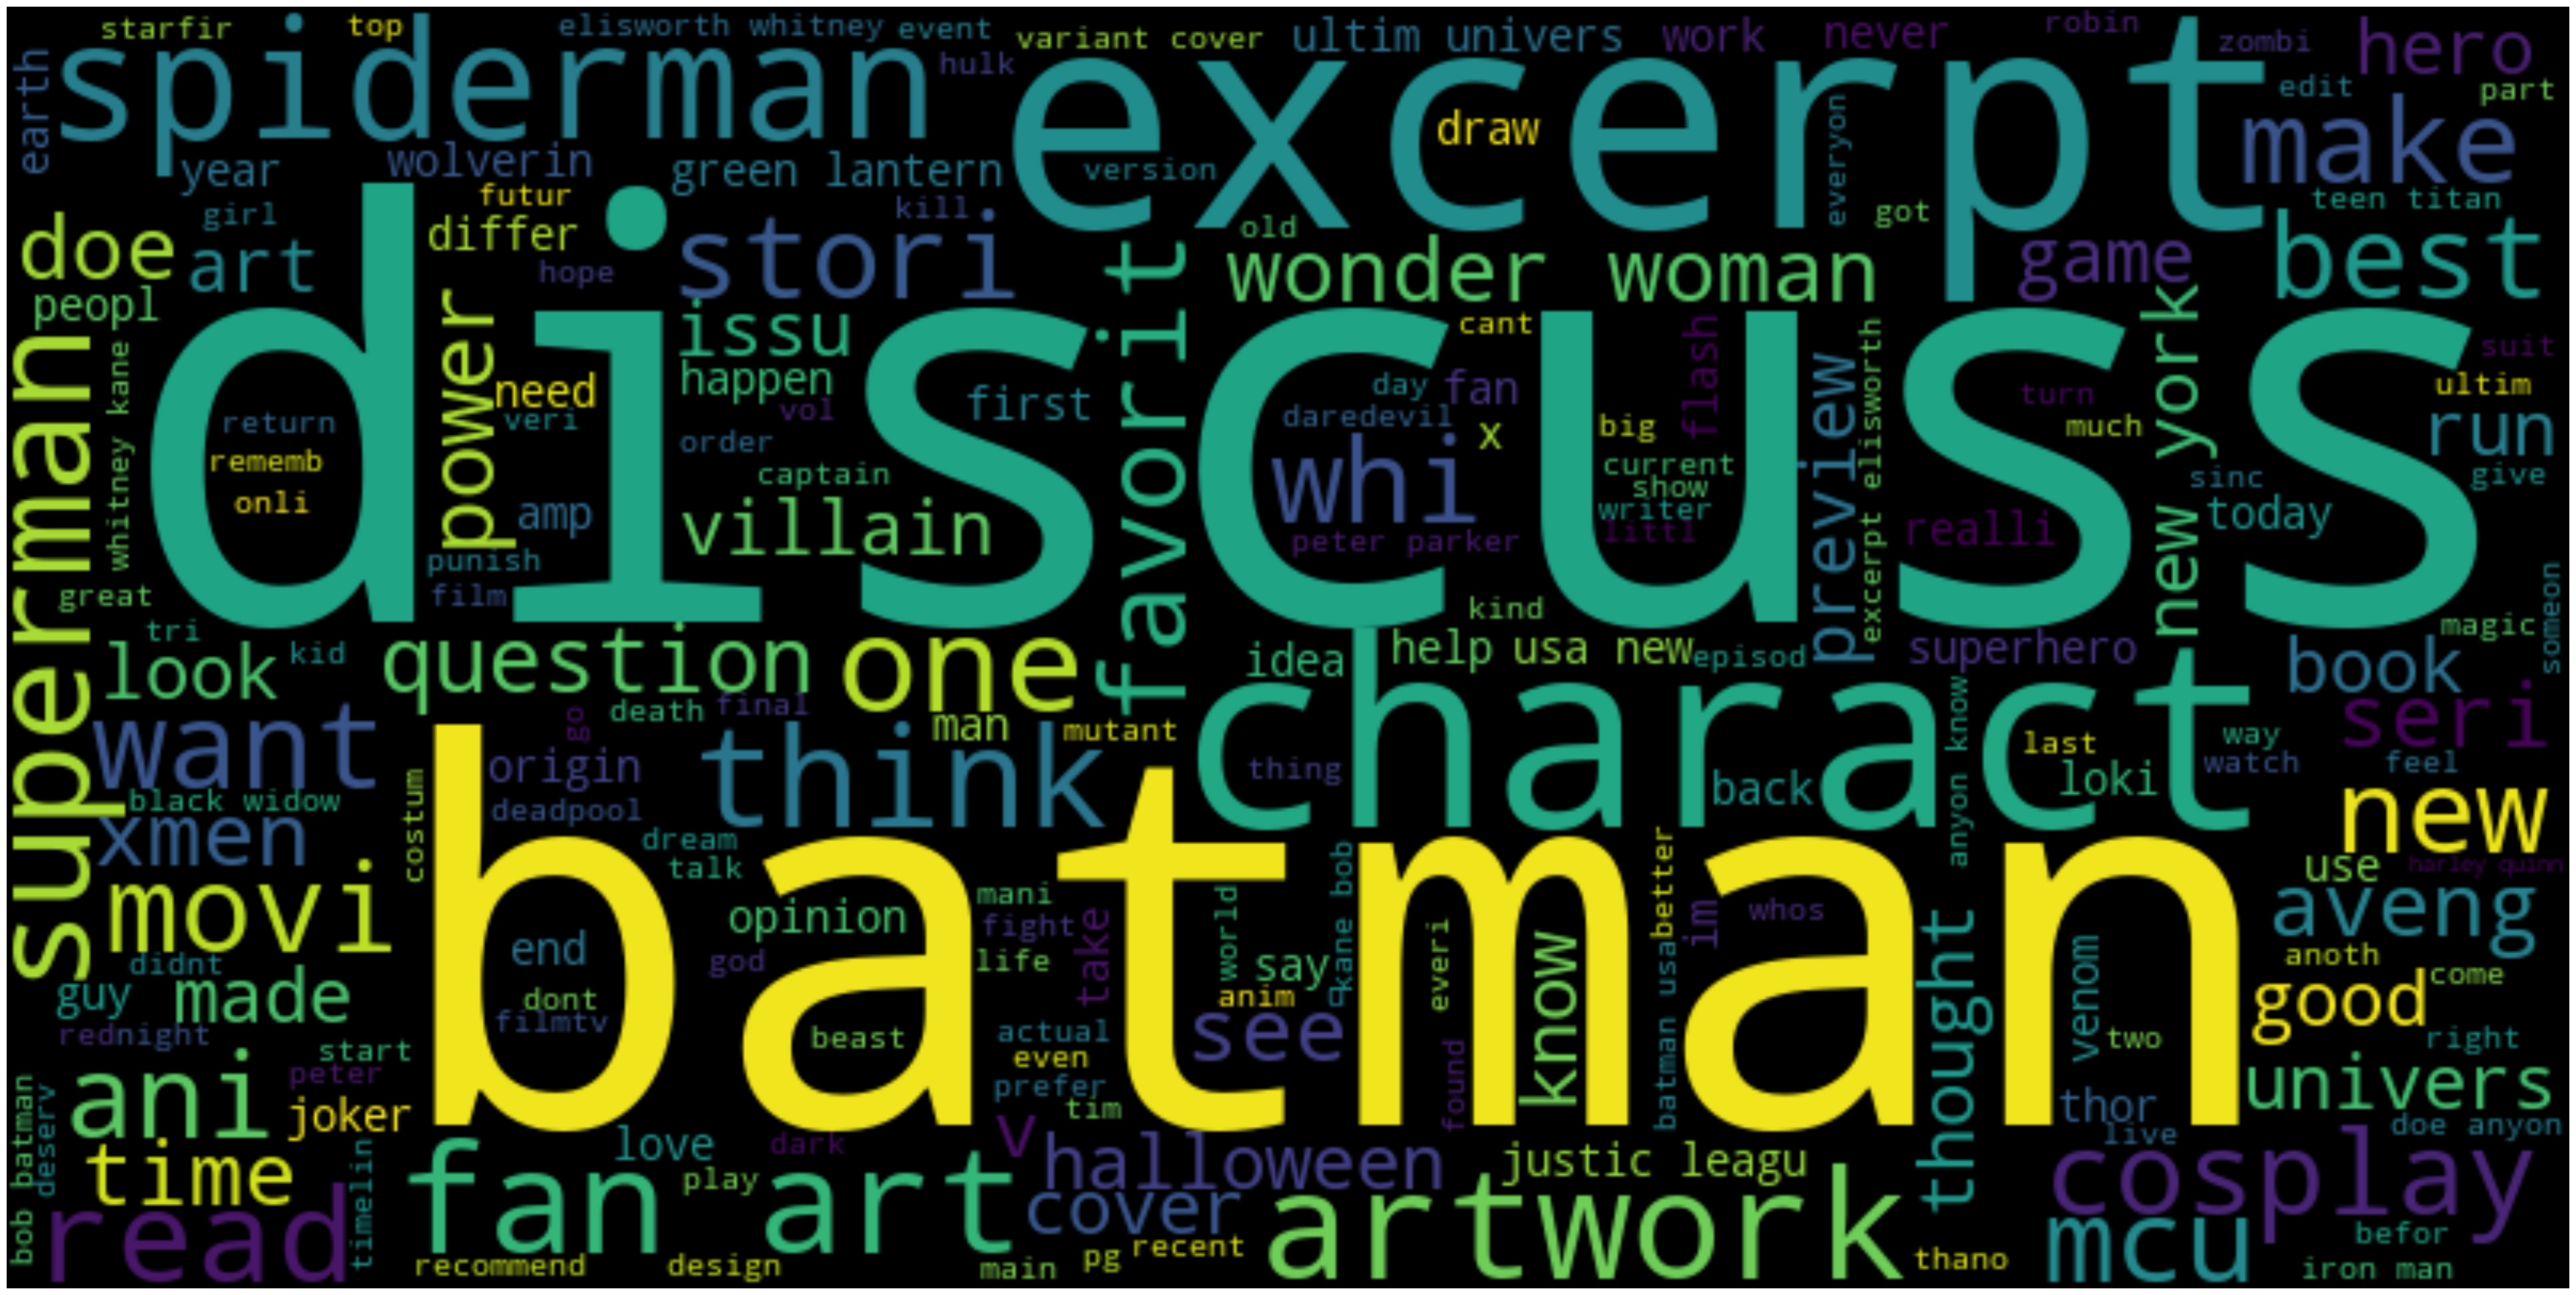

In [17]:
# Concatenate the text from the DataFrame into a single string
text = " ".join(df['title'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(50, 25))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

(-0.5, 1279.5, 627.5, -0.5)

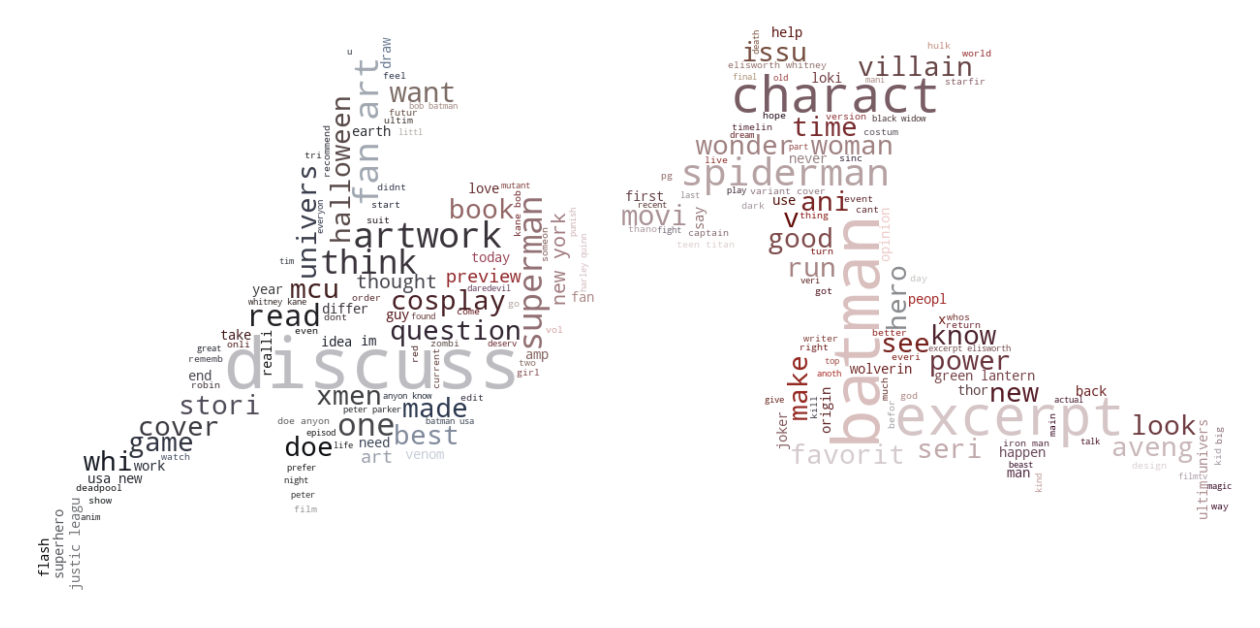

In [18]:
# Load the custom image mask
matplotlib.rcParams['figure.figsize'] = (16.0, 9.0)
mask = np.array(Image.open("hero.jpg"))

wc = WordCloud(background_color="white",width=1280, height=628, mask=mask).generate(text)

# Image Color Generator
image_colors = ImageColorGenerator(mask)

plt.figure()
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

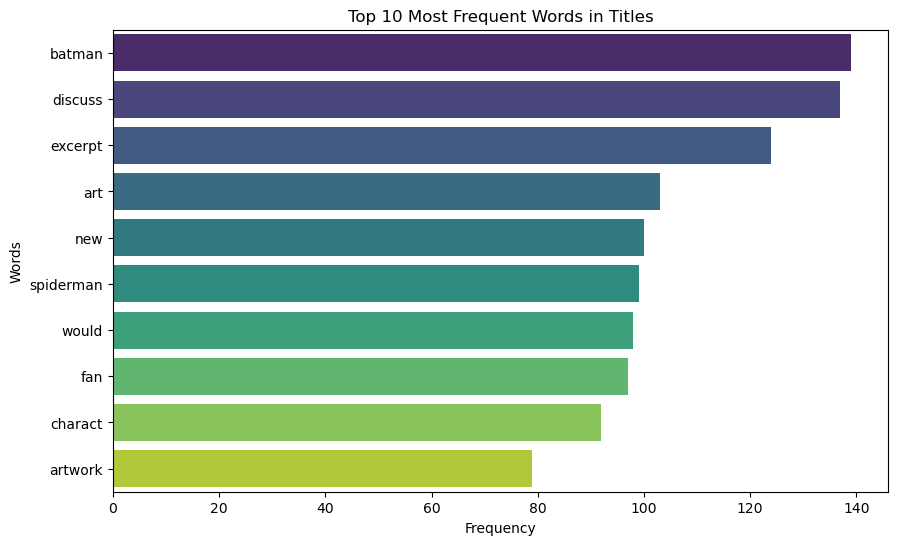

In [19]:
# Tokenize and count words in the 'title' column
all_words = ' '.join(df['title']).lower()  # Combine all titles into a single string
tokenized_words = all_words.split()
filtered_words = [word for word in tokenized_words if word.isalpha() and word not in stopwords.words('english')]  # Remove stopwords

# Count word frequencies
word_counts = Counter(filtered_words)

# Extract the top 10 words and their frequencies
top_words = dict(word_counts.most_common(10))

# Plot the graph
plt.figure(figsize=(10, 6))
sns.barplot(x=list(top_words.values()), y=list(top_words.keys()), palette='viridis')
plt.title('Top 10 Most Frequent Words in Titles')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

In [20]:
def select_model_and_save(df, text_column,model_name, save_column_prefix=None):
    if model_name == "CountVectorizer" :
      model = CountVectorizer()
    elif model_name == 'TfidfVectorizer' :
      model = TfidfVectorizer()
    else:
      print("Model Not correct. Exiting function.")
      return
    # Fit the model on the text column
    model.fit(df[text_column])

    # Transform the text column into a sparse matrix
    transformed_data = model.transform(df[text_column])

    # Convert the sparse matrix to a DataFrame
    transformed_df = pd.DataFrame(transformed_data.toarray(), columns=model.get_feature_names_out())

    # Add the transformed data to the original DataFrame with optional column name prefix
    if save_column_prefix:
        transformed_df.columns = [f"{save_column_prefix}_{text_column}_{col}" for col in transformed_df.columns]

    df = pd.concat([df, transformed_df], axis=1)

    return df

**CountVectorized**

In [21]:
# Call the function to transform and save the data
df_count_vectorize = select_model_and_save(df, 'title','CountVectorizer', 'CountVectorized')
df_count_vectorize = select_model_and_save(df_count_vectorize, 'post_paragraph','CountVectorizer', 'CountVectorized')

In [22]:
df

title  ups  \
0                 week discuss thread tv novemb go edit   14   
1                                 read spooki joke edit    7   
2                                 excerpt detect batman  150   
3                               excerpt moment made sub  118   
4     excerpt cass practic goodby befor fight ladi s...   23   
...                                                 ...  ...   
1829          lego aveng code red offici trailer disney    1   
1830  controversi opinion actual thorough enjoy sheh...    0   
1831                        would bring doctor doom mcu    0   
1832    predat vs wolverin vol bill sienkiewicz variant    1   
1833                                         beast back    1   

                                         post_paragraph  number_of_comments  \
0     hey honorari justic leagu member new week mean...                 117   
1     hello welcom week read topic come one come wee...                   6   
2                                                   nan                  11   
3                                                   nan                   9   
4                                                   nan                   2   
...                                                 ...                 ...   
1829                                                nan                   0   
1830  know lot peopl hate show alot curious whi ani ...                  17   
1831  make villain fantast movi sinc kang descend re...                   1   
1832                                                nan                   0   
1833                                                nan                   0   

      score author_flair_css_class  target  
0        14                    NaN       1  
1         7                    NaN       1  
2       150                    NaN       1  
3       118                    NaN       1  
4        23                    NaN       1  
...     ...                    ...     ...  
1829      1    IronManExtremis two       0  
1830      0                    NaN       0  
1831      0                    NaN       0  
1832      1                    NaN       0  
1833      1                    NaN       0  

[1834 rows x 7 columns]

In [23]:
# Separate features and target variable
X = df[['ups', 'number_of_comments', 'score']]
y = df['target']

# Create and train the model
model = LinearRegression()
model.fit(X, y)

# Access the coefficients
intercept = model.intercept_
coefficients = model.coef_

print(f'Intercept: {intercept}')
print(f'Coefficients: {coefficients}')

Intercept: 0.47370800966063475
Coefficients: [-2.03723789e-05 -9.89702763e-06 -2.03723789e-05]


**TfidfVectorizer**

In [25]:

# Call the function to transform and save the data
df_tfidf_vectorizer = select_model_and_save(df, 'title','TfidfVectorizer', 'TfidfVectorizer')
df_tfidf_vectorizer = select_model_and_save(df_tfidf_vectorizer, 'post_paragraph','TfidfVectorizer', 'TfidfVectorizer')


**Evaluate Function**

In [27]:
def evaluate_model_with_model_name (df_input,model_name):
  print("Evaluate Model:",model_name)
  X = df_input.drop(columns=['target','title','post_paragraph','author_flair_css_class', 'number_of_comments', 'score','ups'])
  y = df_input['target']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 ,random_state=42, stratify=y)
  if model_name == "LogisticRegression" :
    model = LogisticRegression()
  elif model_name == 'KNeighborsClassifier' :
    model = KNeighborsClassifier()
  elif model_name == 'RandomForestClassifier' :
    model = RandomForestClassifier()
  elif model_name == 'ExtraTreesClassifier' :
    model = ExtraTreesClassifier()
  elif model_name == 'NaiveBayes' :
    model = MultinomialNB()
  else:
    print("Model Not correct. Exiting function.")
    return


  model.fit(X_train, y_train)

  # Use cross-validation to assess model performance
  cv_scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation
  print(f'Mean Cross-Validation Score: {cv_scores.mean()}')

  y_pred = model.predict(X_test)
  y_train_pred = model.predict(X_train)
  # Calculate accuracy
  accuracy = accuracy_score(y_train, y_train_pred)
  print("Accuracy on Train:", accuracy)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy on Test:", accuracy)
  # Generate a classification report
  report = classification_report(y_test, y_pred)
  print("Classification Report:")
  print(report)

  # Create a confusion matrix
  conf_matrix = confusion_matrix(y_test, y_pred)
  # Plot the confusion matrix as a heatmap
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['target'].unique(), yticklabels=df['target'].unique())
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()

Evaluate Count-Vectorizer
Evaluate Model: LogisticRegression
Mean Cross-Validation Score: 0.8766176777878387
Accuracy on Train: 0.9959100204498977
Accuracy on Test: 0.8910081743869209
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       195
           1       0.91      0.85      0.88       172

    accuracy                           0.89       367
   macro avg       0.89      0.89      0.89       367
weighted avg       0.89      0.89      0.89       367



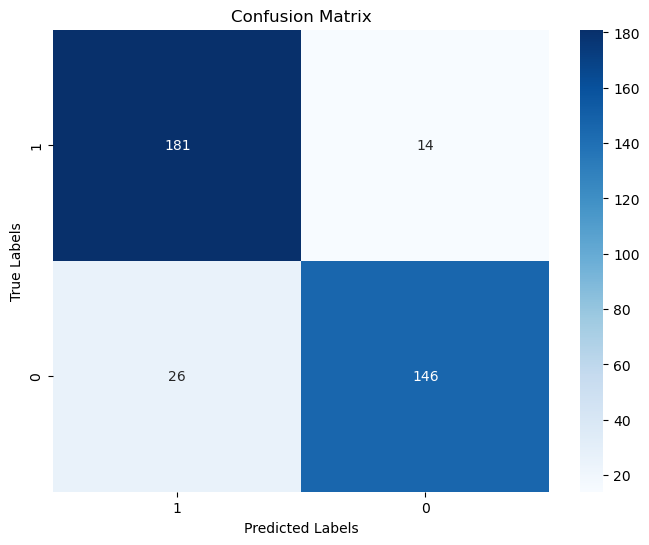

Evaluate Model: RandomForestClassifier
Mean Cross-Validation Score: 0.8841308537066703
Accuracy on Train: 1.0
Accuracy on Test: 0.8991825613079019
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       195
           1       0.92      0.85      0.89       172

    accuracy                           0.90       367
   macro avg       0.90      0.90      0.90       367
weighted avg       0.90      0.90      0.90       367



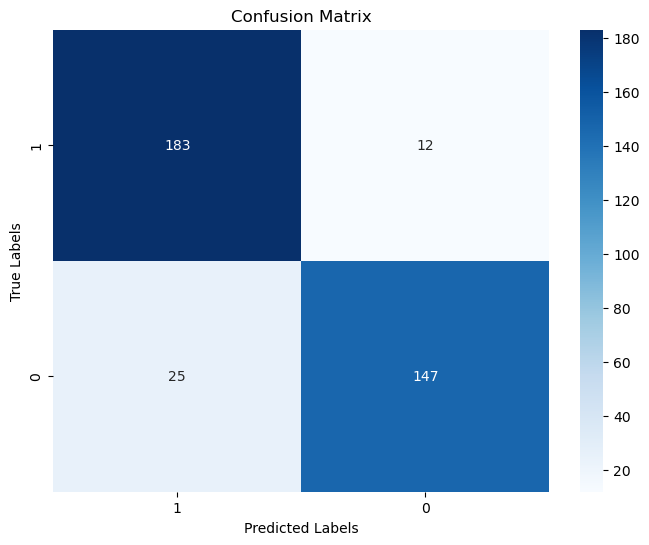

Evaluate Model: ExtraTreesClassifier
Mean Cross-Validation Score: 0.891634742634255
Accuracy on Train: 1.0
Accuracy on Test: 0.8991825613079019
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       195
           1       0.90      0.88      0.89       172

    accuracy                           0.90       367
   macro avg       0.90      0.90      0.90       367
weighted avg       0.90      0.90      0.90       367



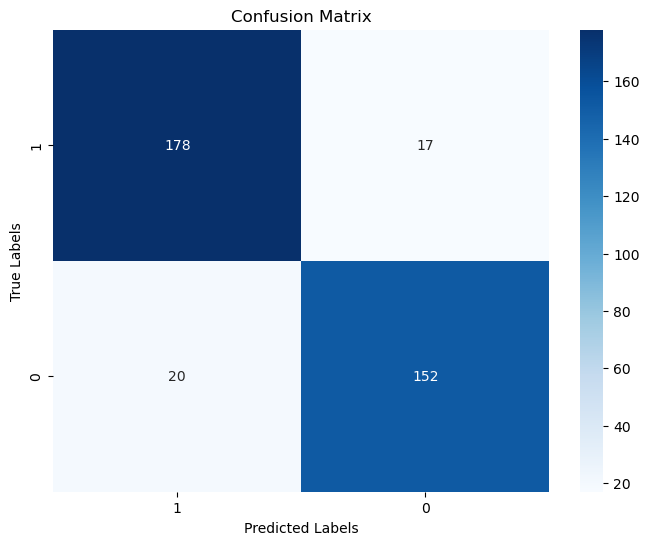

Evaluate Model: NaiveBayes
Mean Cross-Validation Score: 0.8888811497295164
Accuracy on Train: 0.9829584185412407
Accuracy on Test: 0.9100817438692098
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       195
           1       0.88      0.94      0.91       172

    accuracy                           0.91       367
   macro avg       0.91      0.91      0.91       367
weighted avg       0.91      0.91      0.91       367



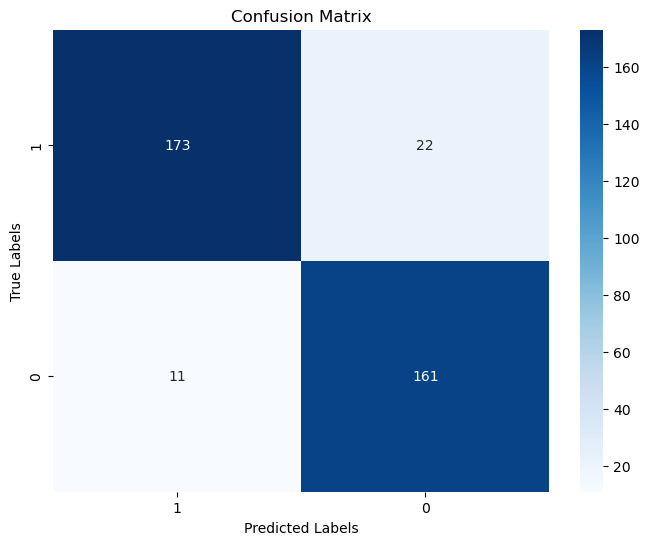

In [39]:
print("Evaluate Count-Vectorizer")
evaluate_model_with_model_name(df_count_vectorize,'LogisticRegression')
#evaluate_model_with_model_name(df_count_vectorize,'KNeighborsClassifier')
evaluate_model_with_model_name(df_count_vectorize,'RandomForestClassifier')
evaluate_model_with_model_name(df_count_vectorize,'ExtraTreesClassifier')
evaluate_model_with_model_name(df_count_vectorize,'NaiveBayes')

Evaluate Tfidf-Vectorizer
Evaluate Model: LogisticRegression
Mean Cross-Validation Score: 0.8711615704302199
Accuracy on Train: 0.9775051124744376
Accuracy on Test: 0.9073569482288828
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92       195
           1       0.95      0.84      0.90       172

    accuracy                           0.91       367
   macro avg       0.91      0.90      0.91       367
weighted avg       0.91      0.91      0.91       367



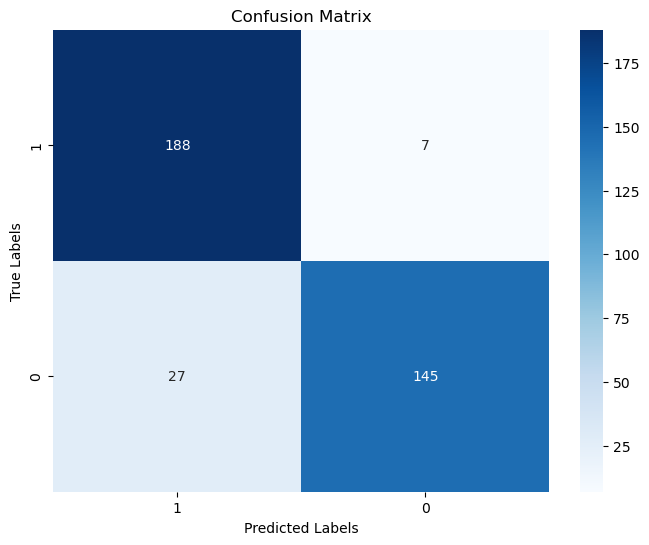

Evaluate Model: RandomForestClassifier
Mean Cross-Validation Score: 0.8793573402057069
Accuracy on Train: 1.0
Accuracy on Test: 0.9019073569482289
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       195
           1       0.92      0.87      0.89       172

    accuracy                           0.90       367
   macro avg       0.90      0.90      0.90       367
weighted avg       0.90      0.90      0.90       367



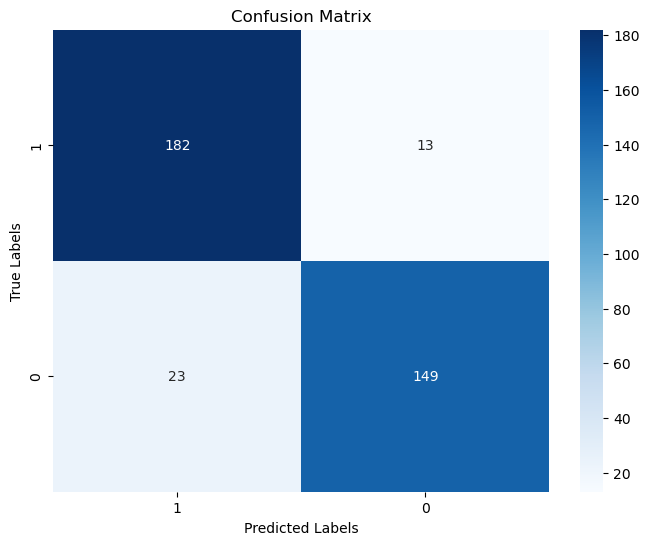

Evaluate Model: ExtraTreesClassifier
Mean Cross-Validation Score: 0.8861832787722598
Accuracy on Train: 1.0
Accuracy on Test: 0.9209809264305178
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       195
           1       0.94      0.88      0.91       172

    accuracy                           0.92       367
   macro avg       0.92      0.92      0.92       367
weighted avg       0.92      0.92      0.92       367



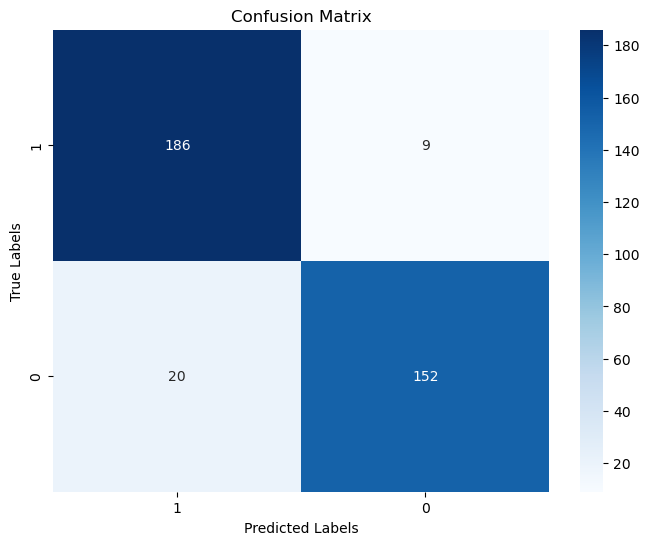

Evaluate Model: NaiveBayes
Mean Cross-Validation Score: 0.8854705021940517
Accuracy on Train: 0.989093387866394
Accuracy on Test: 0.896457765667575
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       195
           1       0.89      0.89      0.89       172

    accuracy                           0.90       367
   macro avg       0.90      0.90      0.90       367
weighted avg       0.90      0.90      0.90       367



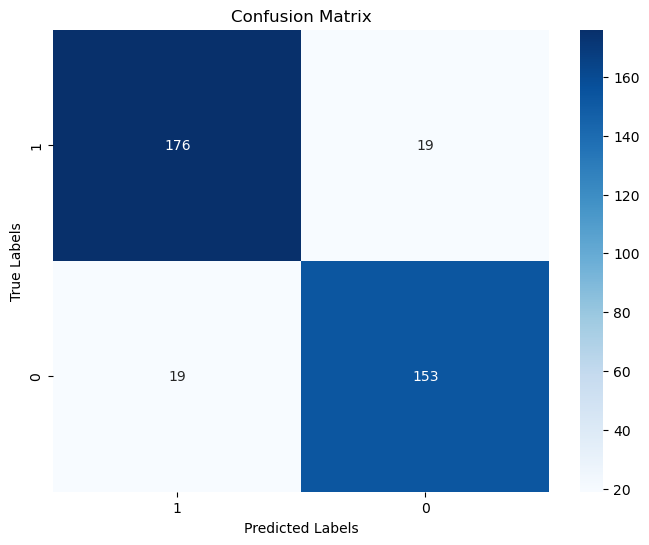

In [40]:
print("Evaluate Tfidf-Vectorizer")
evaluate_model_with_model_name(df_tfidf_vectorizer,'LogisticRegression')
#evaluate_model_with_model_name(df_tfidf_vectorizer,'KNeighborsClassifier')
evaluate_model_with_model_name(df_tfidf_vectorizer,'RandomForestClassifier')
evaluate_model_with_model_name(df_tfidf_vectorizer,'ExtraTreesClassifier')
evaluate_model_with_model_name(df_tfidf_vectorizer,'NaiveBayes')

**Automation Fine-tuning CountVectorizer with MultinomialNB Model**

In [31]:
# Load your data

data = df

# Assume you have a 'text' column and a 'label' column in your dataset
X = data['title']
y = data['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a pipeline with CountVectorizer and MultinomialNB
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

# Define the parameter grid for CountVectorizer and MultinomialNB
param_grid = {
    'vect__max_features': [5000, 10000, 20000],    # Adjust these values based on your data
    'vect__ngram_range': [(1, 1), (1, 2)],          # Adjust these values based on your data
    'vect__stop_words': [None, 'english'],           # Adjust these values based on your data
    'vect__binary': [True, False],                   # Adjust these values based on your data
    'clf__alpha': [0.1, 0.5, 1.0]                    # Adjust these values based on your data
    # Add other hyperparameters for CountVectorizer and MultinomialNB
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters found by grid search
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model with the best parameters on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)

Best Parameters: {'clf__alpha': 1.0, 'vect__binary': True, 'vect__max_features': 10000, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}
Accuracy on Test Set: 0.8664850136239782


In [32]:
def CountVectorizer_param_and_save(df, text_column, save_column_prefix=None):

    model = CountVectorizer(max_features = 10000,ngram_range=(1, 1),stop_words='english',binary=False)

    model.fit(df[text_column])

    # Transform the text column into a sparse matrix
    transformed_data = model.transform(df[text_column])

    # Convert the sparse matrix to a DataFrame
    transformed_df = pd.DataFrame(transformed_data.toarray(), columns=model.get_feature_names_out())

    # Add the transformed data to the original DataFrame with optional column name prefix
    if save_column_prefix:
        transformed_df.columns = [f"{save_column_prefix}_{text_column}_{col}" for col in transformed_df.columns]

    df = pd.concat([df, transformed_df], axis=1)

    return df

In [33]:
df_count_vectorize_new = CountVectorizer_param_and_save(df, 'title','CountVectorizer')
df_count_vectorize_new = CountVectorizer_param_and_save(df_count_vectorize_new, 'post_paragraph','CountVectorizer')

In [35]:
def naiveBayesr_tuneing_model(df_input):
  X = df_input.drop(columns=['target','title','post_paragraph','author_flair_css_class', 'number_of_comments', 'score','ups'])
  y = df_input['target']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 ,random_state=42, stratify=y)
  model = MultinomialNB(alpha=1.0)
  model.fit(X_train, y_train)

  # Use cross-validation to assess model performance
  cv_scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation
  print(f'Mean Cross-Validation Score: {cv_scores.mean()}')

  y_pred = model.predict(X_test)
  y_train_pred = model.predict(X_train)
  # Calculate accuracy
  accuracy = accuracy_score(y_train, y_train_pred)
  print("Accuracy on Train:", accuracy)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy on Test:", accuracy)
  # Generate a classification report
  report = classification_report(y_test, y_pred)
  print("Classification Report:")
  print(report)
  # Create a confusion matrix
  conf_matrix = confusion_matrix(y_test, y_pred)

  # Plot the confusion matrix as a heatmap
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['target'].unique(), yticklabels=df['target'].unique())
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()


Mean Cross-Validation Score: 0.887522927259641
Accuracy on Train: 0.9822767552828903
Accuracy on Test: 0.9182561307901907
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       195
           1       0.89      0.94      0.91       172

    accuracy                           0.92       367
   macro avg       0.92      0.92      0.92       367
weighted avg       0.92      0.92      0.92       367



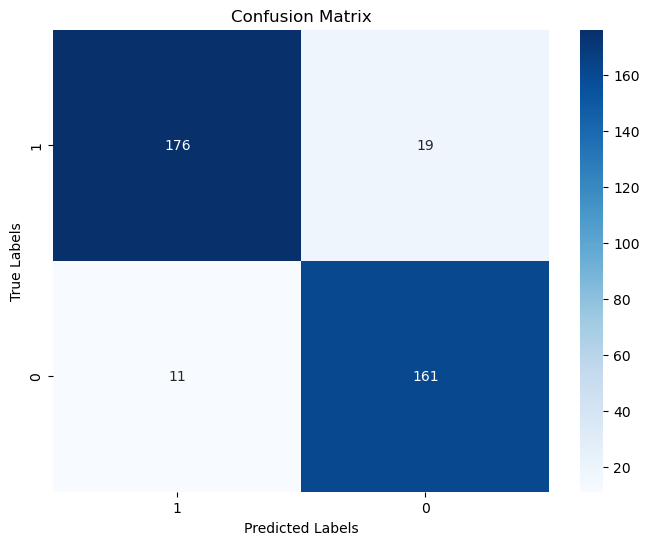

In [36]:
naiveBayesr_tuneing_model(df_count_vectorize_new)

In [37]:
df

title  ups  \
0                 week discuss thread tv novemb go edit   14   
1                                 read spooki joke edit    7   
2                                 excerpt detect batman  150   
3                               excerpt moment made sub  118   
4     excerpt cass practic goodby befor fight ladi s...   23   
...                                                 ...  ...   
1829          lego aveng code red offici trailer disney    1   
1830  controversi opinion actual thorough enjoy sheh...    0   
1831                        would bring doctor doom mcu    0   
1832    predat vs wolverin vol bill sienkiewicz variant    1   
1833                                         beast back    1   

                                         post_paragraph  number_of_comments  \
0     hey honorari justic leagu member new week mean...                 117   
1     hello welcom week read topic come one come wee...                   6   
2                                                   nan                  11   
3                                                   nan                   9   
4                                                   nan                   2   
...                                                 ...                 ...   
1829                                                nan                   0   
1830  know lot peopl hate show alot curious whi ani ...                  17   
1831  make villain fantast movi sinc kang descend re...                   1   
1832                                                nan                   0   
1833                                                nan                   0   

      score author_flair_css_class  target  
0        14                    NaN       1  
1         7                    NaN       1  
2       150                    NaN       1  
3       118                    NaN       1  
4        23                    NaN       1  
...     ...                    ...     ...  
1829      1    IronManExtremis two       0  
1830      0                    NaN       0  
1831      0                    NaN       0  
1832      1                    NaN       0  
1833      1                    NaN       0  

[1834 rows x 7 columns]

In [38]:
data = df

# Assume you have a 'text' column and a 'label' column in your dataset
X = data['title']
y = data['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CountVectorizer to convert text data into numerical features
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Initialize the Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()

# Train the classifier
naive_bayes_classifier.fit(X_train_vectorized, y_train)

# Make predictions on the test set
y_pred = naive_bayes_classifier.predict(X_test_vectorized)

# Show mispredictions
misclassified_indices = y_test != y_pred
misclassified_texts = X_test[misclassified_indices]
true_labels = y_test[misclassified_indices]
predicted_labels = y_pred[misclassified_indices]

for text, true_label, predicted_label in zip(misclassified_texts, true_labels, predicted_labels):
    print(f'Text: {text}\nTrue Label: {true_label}\nPredicted Label: {predicted_label}\n{"-"*50}')

Text: comrad hero love read
True Label: 1
Predicted Label: 0
--------------------------------------------------
Text: absolut carnag omnibus order
True Label: 0
Predicted Label: 1
--------------------------------------------------
Text: would stepford wive life model decoy
True Label: 0
Predicted Label: 1
--------------------------------------------------
Text: loki amp mobius fan art
True Label: 0
Predicted Label: 1
--------------------------------------------------
Text: read chang leav edit
True Label: 1
Predicted Label: 0
--------------------------------------------------
Text: okay know sound crazi spiderman got effect goblin toxin like batman arkham joker toxin question
True Label: 0
Predicted Label: 1
--------------------------------------------------
Text: start
True Label: 1
Predicted Label: 0
--------------------------------------------------
Text: nightwinggrayson rec dont focus much romant relationship
True Label: 1
Predicted Label: 0
---------------------------------------